In [1]:
import torch
import numpy as np
import os,sys
import time
import math
sys.path.append('../..')
#parametres 
data_set_name='gowalla'
device='cuda:4'
rerank_topk=20
topk=20
optimizer=lambda params: torch.optim.Adam(params, lr=1e-3, amsgrad=True)
have_processed_data=True
tree_num=4
num_layers=1#layer of transformer
k=18#the branch of each tree
n_head=4
d_model=96


train_sample_seg_cnt=10#the training data is located in the train_sample_seg_cnt datafiles
parall=10
seq_len=70 # se_len-1 is the number of behaviours in all the windows
min_seq_len=15
test_user_num=1000# the number of user in test file
raw_data_file='../../data/{}/{}.txt'.format(data_set_name,data_set_name)
train_instances_file='../../data/{}/train_instances'.format(data_set_name)
test_instances_file='../../data/{}/test_instances'.format(data_set_name)
validation_instances_file='../../data/{}/validation_instances'.format(data_set_name)
item_num_node_num_file='../../data/{}/item_node_num.txt'.format(data_set_name)
train_item_vec_file='../../data/{}/train_item_vec.npy'.format(data_set_name)
#item_to_code_file='../../data/{}/item_to_code.npy'.format(data_set_name)
#code_to_item_file='../../data/{}/code_to_item.npy'.format(data_set_name)
DIN_Model_path='../../data/{}/DIN_MODEL.pt'.format(data_set_name)
tree_has_generated=True
init_way='embkm'
max_iters=100
feature_ratio=1.0
reranker="Trm"
total_batch_num=20000

test_batch_size=50
item_to_code_file_list=[]
code_to_item_file_list=[]
for tree_id in range(tree_num):
    item_to_code_file='../../data/{}/tree/{}{}_item_to_code_tree_id_{}_k{}.npy'.format(data_set_name,init_way,feature_ratio,tree_id,k)
    code_to_item_file='../../data/{}/tree/{}{}_code_to_item_tree_id_{}_k{}.npy'.format(data_set_name,init_way,feature_ratio,tree_id,k)
    item_to_code_file_list.append(item_to_code_file)
    code_to_item_file_list.append(code_to_item_file)
#assert tree_num==1

eps=0.000001
if device!='cpu':
    torch.cuda.set_device(device)
    device='cuda'
%load_ext autoreload
%autoreload 2
from lib import Trm4Rec

In [2]:
# ##load DIN model which is the ranker for fine-ranking
# from lib import DeepInterestNetwork as DIN
# DIN_Model=torch.load(DIN_Model_path,map_location=torch.device(device))
# DIN_Model.eval()
# pass

In [3]:
import lib
from lib import generate_train_and_test_data
import gc
import numpy as np
if not have_processed_data:
    behavior_dict, train_sample, test_sample,validation_sample,user_num,item_num = _read(raw_data_file,test_user_num)  # 20 is the test users
    # write the training instance into different train_sample_seg_cnt files， avoid that a file is too large
    # stat record the click frequency of each item
    # seq_len=20 min that 19 behaviors and one label
    stat = _gen_train_sample(train_sample, train_instances_file,test_sample=test_sample,validation_sample=validation_sample,
                                                    train_sample_seg_cnt=train_sample_seg_cnt,
                                                    parall=parall, seq_len=seq_len, min_seq_len=min_seq_len)
    _gen_test_sample(test_sample, test_instances_file, seq_len=seq_len,min_seq_len=min_seq_len)
    _gen_test_sample(validation_sample, validation_instances_file, seq_len=seq_len,min_seq_len=min_seq_len)
    del behavior_dict
    del train_sample
    del test_sample
    del stat
    #np.savetxt(item_num_node_num_file,np.array([user_num,item_num]),fmt='%d',delimiter=',')
else:
    [user_num,item_num]=np.loadtxt(item_num_node_num_file,dtype=np.int32,delimiter=',')
print('user num is {}, item is {}'.format(user_num,item_num))

user num is 13583, item is 71436


In [4]:
from lib.generate_training_batches import Train_instance
train_instances=Train_instance(parall=parall)
#training_batch_generator=train_instances.training_batches(train_instances_file,train_sample_seg_cnt,item_num,batchsize=training_batch_size)
training_data,training_labels=train_instances.get_training_data(train_instances_file,train_sample_seg_cnt,item_num)
#test_batch_generator=train_instances.test_batches(test_instances_file,item_num,batchsize=test_batch_size)
validation_batch_generator=train_instances.validation_batches(validation_instances_file,item_num,batchsize=test_batch_size)
test_instances=train_instances.read_test_instances_file(test_instances_file,item_num)

In [5]:
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values
loss_history,dev_precision_history,dev_recall_history,dev_f_measure_history,dev_novelty_history,policy_acc,dev_hr_history,dev_ndcg_history,dev_map_history=[],[],[],[],[],[],[],[],[]
total_precision_history,total_recall_history,total_f_measure_history,total_novelty_history,total_hr_history,total_ndcg_history,total_map_history=[],[],[],[],[],[],[]

In [6]:
def presision(result_list,gt_list,top_k):
    count=0.0
    for r,g in zip(result_list,gt_list):
        count+=len(set(r).intersection(set(g)))
    return count/(top_k*len(result_list))
def recall(result_list,gt_list):
    t=0.0
    for r,g in zip(result_list,gt_list):
        t+=1.0*len(set(r).intersection(set(g)))/len(g)
    return t/len(result_list)
def f_measure(result_list,gt_list,top_k,eps=1.0e-9):
    f=0.0
    for r,g in zip(result_list,gt_list):
        recc=1.0*len(set(r).intersection(set(g)))/len(g)
        pres=1.0*len(set(r).intersection(set(g)))/top_k
        if recc+pres<eps:
            continue
        f+=(2*recc*pres)/(recc+pres)
    return f/len(result_list)
def novelty(result_list,s_u,top_k):
    count=0.0
    for r,g in zip(result_list,s_u):
        count+=len(set(r)-set(g))
    return count/(top_k*len(result_list))
def hit_ratio(result_list,gt_list):
    intersetct_set=[len(set(r)&set(g)) for r,g in zip(result_list,gt_list)]
    return 1.0*sum(intersetct_set)/sum([len(gts) for gts in gt_list])

def NDCG(result_list,gt_list):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        sorted_indicator=indicator[indicator.argsort(-1)[::-1]]
        if 1 in indicator:
            t+=np.sum(indicator / np.log2(1.0*np.arange(2,len(indicator)+ 2)))/\
               np.sum(sorted_indicator/np.log2(1.0*np.arange(2,len(indicator)+ 2)))
    return t/len(gt_list)

def MAP(result_list,gt_list,topk):
    t=0.0
    for re,gt in zip(result_list,gt_list):
        setgt=set(gt)
        indicator=np.asfarray([1 if r in setgt else 0 for r in re])
        t+=np.mean([indicator[:i].sum(-1)/i for i in range(1,topk+1)],axis=-1)
    return t/len(gt_list)

In [7]:
data = None
train_model_list = []
for i in range(tree_num):
    train_model = Trm4Rec(item_num=int(item_num),
                          user_seq_len=seq_len-1,
                          d_model=d_model,
                          nhead=n_head,
                          device=device,
                          optimizer=optimizer,
                          num_layers=num_layers,
                          k=k,
                          item_to_code_file=item_to_code_file_list[i],
                          code_to_item_file=code_to_item_file_list[i],
                          tree_has_generated=tree_has_generated,
                          init_way=init_way,
                          max_iters=max_iters,
                          feature_ratio=feature_ratio,
                          data=data,#used for kmeans tree
                          parall=parall)
    if i > 0:
        train_model.trm_model.trm.encoder = train_model_list[0].trm_model.trm.encoder
    train_model_list.append(train_model)

In [8]:
# model_file='../../data/{}/model/{}{}_model_encoder_k{}.pt'.format(data_set_name,init_way,feature_ratio,k)
# model_encoder = torch.load(model_file,map_location=torch.device(device))
# for tree_id in range(tree_num):
#     model_file='../../data/{}/model/{}{}_model_decoder_tree_id_{}_k{}.pt'.format(data_set_name,init_way,feature_ratio,tree_id,k)
#     train_model_list[tree_id].trm_model.trm.encoder = model_encoder
#     train_model_list[tree_id].trm_model.trm.decoder = torch.load(model_file,map_location=torch.device(device))
#     train_model_list[tree_id].trm_model.eval()

In [9]:
model_parameters = list(train_model_list[0].trm_model.trm.encoder.parameters())
for i in range(tree_num):
    model_parameters += list(train_model_list[i].trm_model.trm.decoder.parameters())
model_optimizer = optimizer(model_parameters)

In [10]:
def rerank(batch_x,label,top_k=rerank_topk,tree_num=11):
    #all_time = 0
    #start_time = time.time()
    if tree_num == 1:
        return label
    #final_result=torch.full((len(batch_x),top_k),-1,dtype=torch.int64,device=device)
    scores = torch.full((len(batch_x),top_k*tree_num),-1e15,device=device)
    input_labels = torch.zeros((len(batch_x),top_k*tree_num),dtype=torch.int64,device=device)
    max_lenr  = top_k
    for i,user,result in zip(range(len(batch_x)),batch_x,label):
        r=torch.LongTensor(list(set(result.tolist())))
        scores[i,0:len(r)]=0.0
        input_labels[i,0:len(r)]=r
        max_lenr = max(max_lenr,len(r))
    scores = scores[:,0:max_lenr]
    input_labels = input_labels[:,0:max_lenr]
    input_user = batch_x.repeat_interleave(max_lenr,dim=0)
    input_item = input_labels.reshape(-1)
    #all_time += time.time() - start_time
    #print('all_time',all_time)
    with torch.no_grad():
        for j in range(tree_num):
            #torch.cuda.empty_cache()
            #time.sleep(0.5)
            #start_time = time.time()
            scores += train_model_list[j].compute_scores(\
                    input_user,\
                    input_item).sum(-1).view(batch_x.shape[0],-1)
            #print(scores.shape,temp_scores.shape)
            #scores = scores + temp_scores
            #all_time += time.time()-start_time
            #print('all_time',all_time)
        #start_time = time.time()
        argindex=scores.argsort(-1,True)[:,:top_k]
        final_result=input_labels.gather(index=argindex,dim=-1)
    return final_result

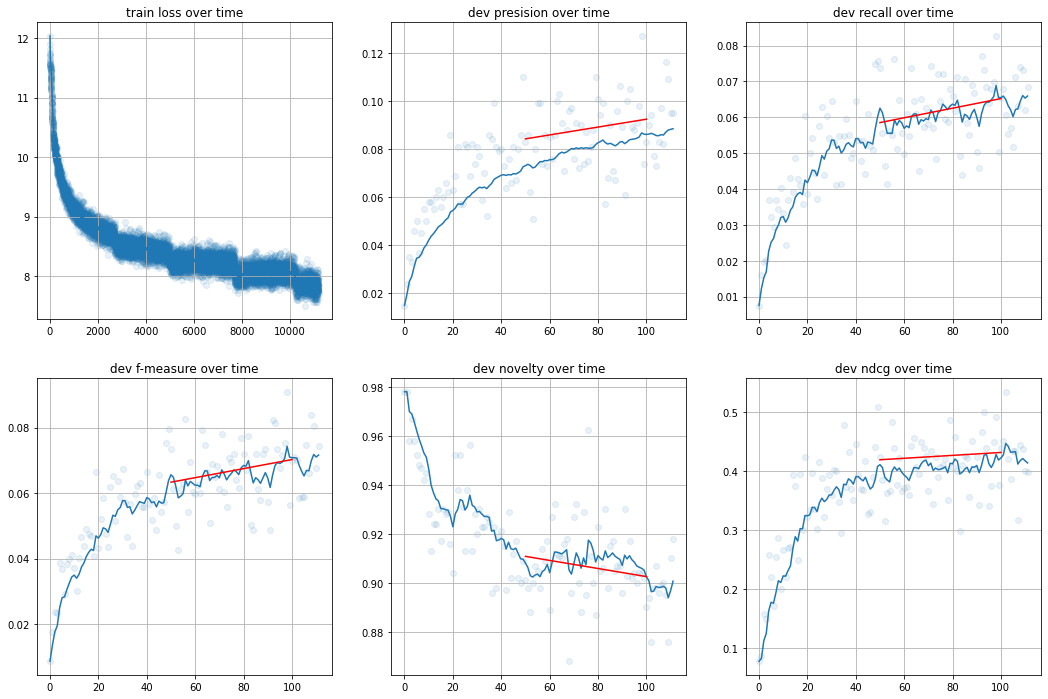

step=11202, mean_loss=7.841, time=1.000
____________________________________________________________________________________________________


/amax/home/fengchao/anaconda3/envs/torch170/lib/python3.6/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:531: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


KeyboardInterrupt: 

In [26]:
num_batch = math.ceil(test_instances.shape[0]/test_batch_size)
for i in range(tree_num):
    train_model_list[i].trm_model.train()
validation_batch_generator=train_instances.validation_batches(validation_instances_file,item_num,batchsize=test_batch_size)
for (batch_x,batch_y) in train_instances.generate_training_records(training_data,training_labels,batch_size=256):
    #print(batch_x,batch_y)
    #loss=train_model.update_model(batch_x,batch_y)
    loss = 0
    for i in range(tree_num):
        loss+=train_model_list[i].update_model(batch_x,batch_y)
    loss.backward()
    model_optimizer.step()
    model_optimizer.zero_grad()
    loss_history.append(loss.item())
    if train_model_list[0].batch_num%5000==0:
        #train_model.trm_model.eval()
        for i in range(tree_num):
            train_model_list[i].trm_model.eval()
        #result_history=train_model.predict(test_instances,topk=topk).numpy()
        result_history=[]
        for j in range(num_batch):
            batch_result_list = []
            batch_user = test_instances[j*test_batch_size:(j+1)*test_batch_size].to(device)
            for i in range(tree_num):
                batch_result_one_tree = train_model_list[i].predict(batch_user,topk=topk)          
                batch_result_list.append(batch_result_one_tree)
            batch_result = torch.cat(batch_result_list,dim=-1)
            batch_result = rerank(batch_user,batch_result,rerank_topk,tree_num)
            result_history.append(batch_result)
        result_history = torch.cat(result_history,dim=0).cpu().numpy()
        total_precision_history.append(presision(result_history,train_instances.test_labels,rerank_topk))
        total_recall_history.append(recall(result_history,train_instances.test_labels))
        total_f_measure_history.append(f_measure(result_history,train_instances.test_labels,rerank_topk))
        total_novelty_history.append(novelty(result_history,test_instances.tolist(),rerank_topk))
        total_hr_history.append(hit_ratio(result_history,train_instances.test_labels))
        total_ndcg_history.append(NDCG(result_history,train_instances.test_labels))
        total_map_history.append(MAP(result_history,train_instances.test_labels,rerank_topk))

        #train_model.trm_model.train()
        for i in range(tree_num):
            train_model_list[i].trm_model.train()


            
    if train_model_list[0].batch_num% 100 == 0:
        
        ###start to test
        #train_model.trm_model.eval()
        for i in range(tree_num):
            train_model_list[i].trm_model.eval()
        test_batch,test_index=validation_batch_generator.__next__()
        test_batch = test_batch.to(device)
        gt_history=[train_instances.validation_labels[i.item()] for i in test_index]
        #result_history=train_model.predict(test_batch,topk=topk).numpy()
        result_history=[]
        for i in range(tree_num):
            result_history.append(train_model_list[i].predict(test_batch,topk=topk))
        result_history = rerank(test_batch, torch.cat(result_history,dim=-1),tree_num=tree_num).cpu().numpy()
        dev_precision_history.append(presision(result_history,gt_history,rerank_topk))
        dev_recall_history.append(recall(result_history,gt_history))
        dev_f_measure_history.append(f_measure(result_history,gt_history,rerank_topk))
        dev_novelty_history.append(novelty(result_history,test_batch.tolist(),rerank_topk))
        dev_hr_history.append(hit_ratio(result_history,gt_history))
        dev_ndcg_history.append(NDCG(result_history,gt_history))
        dev_map_history.append(MAP(result_history,gt_history,rerank_topk))
        for i in range(tree_num):
            train_model_list[i].trm_model.train()
            

        clear_output(True)
        plt.figure(figsize=[18, 12])
        plt.subplot(2, 3, 1)
        plt.title('train loss over time'); plt.grid();
        plt.plot(moving_average(loss_history, span=50))
        plt.scatter(range(len(loss_history)), loss_history, alpha=0.1)

        plt.subplot(2, 3, 2)
        plt.title('dev presision over time'); plt.grid();
        plt.plot(moving_average(dev_precision_history, span=50))
        plt.scatter(range(len(dev_precision_history)), dev_precision_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_precision_history)) + 1), total_precision_history, c='r')
        
        plt.subplot(2, 3, 3)
        plt.title('dev recall over time'); plt.grid();
        plt.plot(moving_average(dev_recall_history, span=10))
        plt.scatter(range(len(dev_recall_history)), dev_recall_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_recall_history)) + 1), total_recall_history, c='r')
        
        plt.subplot(2, 3, 4)
        plt.title('dev f-measure over time'); plt.grid();
        plt.plot(moving_average(dev_f_measure_history, span=10))
        plt.scatter(range(len(dev_f_measure_history)), dev_f_measure_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_f_measure_history)) + 1), total_f_measure_history, c='r')
        
        plt.subplot(2, 3, 5)
        plt.title('dev novelty over time'); plt.grid();
        plt.plot(moving_average(dev_novelty_history, span=10))
        plt.scatter(range(len(dev_novelty_history)), dev_novelty_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_novelty_history)) + 1), total_novelty_history, c='r')
        
        plt.subplot(2, 3, 6)
        plt.title('dev ndcg over time'); plt.grid();
        plt.plot(moving_average(dev_ndcg_history, span=10))
        plt.scatter(range(len(dev_ndcg_history)), dev_ndcg_history, alpha=0.1)
        plt.plot(50*(np.arange(len(total_ndcg_history)) + 1), total_ndcg_history, c='r')
        
        plt.show()
        
        print("step=%i, mean_loss=%.3f, time=%.3f" % 
              (len(loss_history), np.mean(loss_history[-100:]),1.0))
        print('_' * 100)
    if train_model_list[0].batch_num > total_batch_num:
        break

In [ ]:
# model_file='../../data/{}/model/{}{}_model_encoder_k{}.pt'.format(data_set_name,init_way,feature_ratio,k)
# torch.save(train_model_list[0].trm_model.trm.encoder,model_file)
# for tree_id in range(tree_num):
#     model_file='../../data/{}/model/{}{}_model_decoder_tree_id_{}_k{}.pt'.format(data_set_name,init_way,feature_ratio,tree_id,k)
#     torch.save(train_model_list[tree_id].trm_model.trm.decoder,model_file)